<h2>Training an image classifier</h2?

<h3>1. Loading and normalizing CIFAR10</h3>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# The output of torchvision datasets are PILImage images of 
# range [0, 1]

In [2]:
transform = transforms.Compose(
    # Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
    [transforms.ToTensor(),
     # Given mean: ``(M1,...,Mn)`` and std: ``(S1,..,Sn)``
     # for ``n`` channels, this transform will normalize each channel 
     # of the input ``torch.*Tensor`` i.e.
     # ``input[channel] = (input[channel] - mean[channel]) / std[channel]``
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

# imgs should be unnormalized to be displayed!

In [3]:
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, 
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, 
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root="./data", train=False,
                                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10,
                                        shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


 ship    dog  truck    car    car  horse   ship    cat   bird  plane 


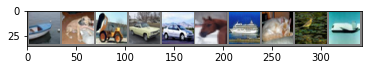

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img * 0.5 + 0.5  # unnormalize!
    
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    
    plt.imshow(npimg)
    
# gets some random training images
dataiter = iter(trainloader)
# gets two tensors (imgs, labels)
# numbers in label are indices in the classes tuple
images, labels = dataiter.next()

# shows images
# torchvision.utils.make_grid() makes imgs a long img
imshow(torchvision.utils.make_grid(images, nrow=10))
# prints labels
print(" ".join("%5s " % classes[labels[j]] for j in range(10)))

<h3>2. Define a Convolutional Neural Network</h2>

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        z1 = self.conv1(x)
        a1 = F.relu(z1)
        a1 = F.max_pool2d(a1, 2)
        
        z2 = self.conv2(a1)
        a2 = F.relu(z2)
        a2 = F.max_pool2d(a2, 2)
        a2 = a2.view(-1, 16 * 5 * 5)
        
        z3 = self.fc1(a2)
        a3 = F.relu(z3)
        
        z4 = self.fc2(a3)
        a4 = F.relu(z4)
        
        a5 = self.fc3(a4)
        
        return a5
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


<h3>3. Define a Loss function and optimizer</h3>

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

<h3>4. Train the network</h3>

In [7]:
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # retrieves imgs, labels
        # batch number for inputs: 10
        inputs, labels = data
        
        # zeroes the param gds
        optimizer.zero_grad()
        
        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # updates params
        optimizer.step()
        
        # displays statistics
        running_loss += loss.item()
        if i % 2000 == 1999:
            print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, 
                                            running_loss / 2000))
            running_loss = 0.0

print("Finished Training")

[1,  2000] loss: 2.131
[1,  4000] loss: 1.746
[2,  2000] loss: 1.496
[2,  4000] loss: 1.433
Finished Training


In [8]:
# saves the model
PATH = "./cifar_net.pth"
torch.save(net.state_dict(), PATH)

<h3>5. Test the network on the test data</h5>

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car


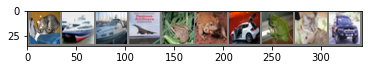

In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images, nrow=10))
print("GroundTruth: ", ' '.join("%5s" % classes[labels[j]] for 
                                j in range(10)))

In [10]:
# loads back the model
state_dict = torch.load(PATH)
net = Net()
net.load_state_dict(state_dict)

<All keys matched successfully>

In [11]:
# tests the model wieh some samples

In [12]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)
print("Predicted: ", ' '.join("%5s" % classes[predicted[j]] 
                              for j in range(10)))

Predicted:   frog  ship   car  ship  frog  frog   car  frog   dog   car


In [13]:
# tests the model with the whole test set

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        # retrieves imgs, labels
        images, labels = data
        
        # predicts using the trained model
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        
        # updates counters
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print("Accuracy of the network on the 10000 test images: %d %%" % 
      (100 * correct / total))

Accuracy of the network on the 10000 test images: 51 %


In [15]:
# sees how well each class performs
class_correct = list(0 for i in range(10))
class_total = list(0 for i in range(10))
with torch.no_grad():
    for data in testloader:
        # retrieves imgs, labels
        images, labels = data
        
        # predicts using the trained model
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        
        # updates counters
        c = (predicted == labels)
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print("Accuracy of %5s : %2d %%" % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 58 %
Accuracy of   car : 52 %
Accuracy of  bird : 27 %
Accuracy of   cat : 14 %
Accuracy of  deer : 35 %
Accuracy of   dog : 61 %
Accuracy of  frog : 72 %
Accuracy of horse : 60 %
Accuracy of  ship : 55 %
Accuracy of truck : 74 %


<h3>Training on GPU</h3>

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() 
                      else "cpu")
print(device)

cuda


In [17]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [18]:
# sends the inputs and targets at every step to the gpu
inputs, labels = data[0].to(device), data[1].to(device)